# Определение перспективного тарифа для телеком-компании


# Описание проекта

## Основная задача: 
Необходимо установить параметры для определения рыночной стоимости объектов недвижимости.

## Цель:
На основании проведенного анализа будет построена автоматизированная система, которая будет отслеживать аномалии и мошенническую деятельность.

# Описание тарифов

Тариф «Смарт»
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

Примечание

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

# Описание данных

Таблица calls (информация о звонках):
- <i>id</i> — уникальный номер звонка
- <i>call_date</i> — дата звонка
- <i>duration</i> — длительность звонка в минутах
- <i>user_id</i> — идентификатор пользователя, сделавшего звонок

Таблица internet (информация об интернет-сессиях):
- <i>id</i> — уникальный номер сессии
- <i>mb_used</i> — объём потраченного за сессию интернет-трафика (в мегабайтах)
- <i>session_date</i> — дата интернет-сессии
- <i>user_id</i> — идентификатор пользователя

Таблица messages (информация о сообщениях):
- <i>id</i> — уникальный номер сообщения
- <i>message_date</i> — дата сообщения
- <i>user_id</i> — идентификатор пользователя, отправившего сообщение

Таблица tariffs (информация о тарифах):
- <i>tariff_name</i> — название тарифа
- <i>rub_monthly_fee</i> — ежемесячная абонентская плата в рублях
- <i>minutes_included</i> — количество минут разговора в месяц, включённых в абонентскую плату
- <i>messages_included</i> — количество сообщений в месяц, включённых в абонентскую плату
- <i>mb_per_month_included</i> — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- <i>rub_per_minute</i> — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- <i>rub_per_message</i> — стоимость отправки сообщения сверх тарифного пакета
- <i>rub_per_gb</i> — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Таблица users (информация о пользователях):
- <i>user_id</i> — уникальный идентификатор пользователя
- <i>first_name</i> — имя пользователя
- <i>last_name</i> — фамилия пользователя
- <i>age</i> — возраст пользователя (годы)
- <i>reg_date</i> — дата подключения тарифа (день, месяц, год)
- <i>churn_date</i> — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- <i>city</i> — город проживания пользователя
- <i>tariff</i> — название тарифного плана


## Загрузка и первичный анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st


In [2]:
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
calls = pd.read_csv('./calls.csv')
internet = pd.read_csv('./internet.csv')
messages = pd.read_csv('./messages.csv')
tariffs = pd.read_csv('./tariffs.csv')
users = pd.read_csv('./users.csv')


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [6]:
calls.describe()

,duration,user_id
count,"202,607.00","202,607.00"
mean,6.76,"1,253.94"
std,5.84,144.72
min,0.00,"1,000.00"
25%,1.30,"1,126.00"
50%,6.00,"1,260.00"
75%,10.70,"1,379.00"
max,38.00,"1,499.00"


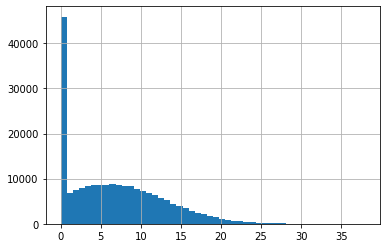

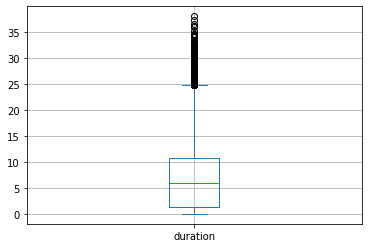

In [7]:
calls['duration'].hist(bins = 50);
plt.show()
calls['duration'].plot(kind='box', grid=True);

Перед работой, связанной с проверкой гипотез, необходимо выполнить следующие действия:
- <i>call_date</i> - привести к типу datetime
- <i>duration</i> - проанализировать на предмет аномалий (об этом говорит наличие статистических выбросов, возможно они связаны с разным количеством пользователей по тарифам))


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [9]:
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [10]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,"149,396.00","149,396.00","149,396.00"
mean,"74,697.50",370.19,"1,252.10"
std,"43,127.05",278.30,144.05
min,0.00,0.00,"1,000.00"
25%,"37,348.75",138.19,"1,130.00"
50%,"74,697.50",348.01,"1,251.00"
75%,"112,046.25",559.55,"1,380.00"
max,"149,395.00","1,724.83","1,499.00"


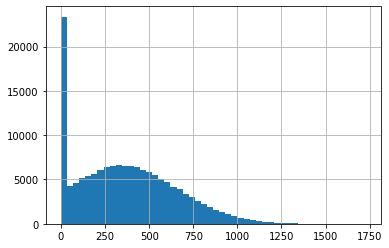

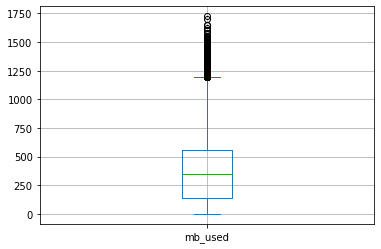

In [11]:
internet['mb_used'].hist(bins = 50);
plt.show()
internet['mb_used'].plot(kind='box', grid=True);

Перед работой, связанной с проверкой гипотез, необходимо выполнить следующие действия:
- <i>Unnamed: 0</i> - столбец, дублирующий индекс, необходимо удалить
- <i>mb_used</i> - проанализировать на предмет аномалий (об этом говорит наличие статистических выбросов, возможно они связаны с разным количеством пользователей по тарифам)
- <i>session_date</i> - привести к типу datetime

In [12]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [13]:
messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [14]:
messages.describe()

,user_id
count,"123,036.00"
mean,"1,256.99"
std,143.52
min,"1,000.00"
25%,"1,134.00"
50%,"1,271.00"
75%,"1,381.00"
max,"1,499.00"


Перед работой, связанной с проверкой гипотез, необходимо выполнить следующие действия:
- <i>message_date</i> - привести к типу datetime

In [15]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [16]:
tariffs.head(5)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [18]:
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Перед работой, связанной с проверкой гипотез, необходимо выполнить следующие действия:
- <i>reg_date</i> - привести к типу datetime
- <i>churn_date</i> - привести к типу datetime

В предложенных таблицах отсутствуют пропущенные данные (кроме поля <i>chunk</i> в таблице <i>users</i> , но там пропущенные знания объясняются внутренней логикой таблицы). Присутствуют некорректные типы данных - для дат во всех таблицах, и нужна проверка на наличие аномальных данных. 

## Предобработка данных

### Преобразование типов

In [19]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d', errors = "ignore")
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d', errors = "ignore")
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d', errors = "ignore")
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d', errors = "ignore")
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d', errors = "ignore")

Поля, содержащие значения дат преобразованы в тип datetime.

### Удаление лишних полей

In [20]:
internet = internet.drop(labels = ['Unnamed: 0'], axis=1)

In [21]:
internet.columns

Index(['id', 'mb_used', 'session_date', 'user_id'], dtype='object')

Лишнее поле <i>'Unnamed: 0'</i> в таблице <i>internet</i> было удалено.

### Исправление ошибок

#### Проверка на отрицательные значения данных по продолжительности звонков и объему траффика

In [22]:
neg_calls = len(calls[calls['duration'] < 0])
neg_internet = len(internet[internet['mb_used'] < 0])
print(f'Кол-во вызовов с отрицательной длительностью: {neg_calls} шт.')
print(f'Кол-во интернет-сессий с отрицательным траффиком: {neg_internet} шт.')


Кол-во вызовов с отрицательной длительностью: 0 шт.
Кол-во интернет-сессий с отрицательным траффиком: 0 шт.


#### Проверка данных пользователей

In [23]:
users_dupl = users.groupby(['first_name', 'last_name'])['user_id'].count()
usersc_dupl_count = len(users_dupl[users_dupl>1])
print(f'Кол-во пользователей, заведенных несколько раз: {usersc_dupl_count} шт.')

Кол-во пользователей, заведенных несколько раз: 0 шт.


In [24]:
wrong_dates = len(users[users['churn_date'] <= users['reg_date']])
print(f'Кол-во пользователей, с неправильными датами регистрации и отключения: {usersc_dupl_count} шт.')

Кол-во пользователей, с неправильными датами регистрации и отключения: 0 шт.


In [25]:
calls_date = calls.groupby(['user_id'])['call_date'].agg(['min', 'max']).reset_index()
calls_date.columns = ['user_id', 'calls_min', 'calls_max']

messages_date = messages.groupby(['user_id'])['message_date'].agg(['min', 'max']).reset_index()
messages_date.columns = ['user_id', 'message_min', 'messages_max']

internet_date = internet.groupby(['user_id'])['session_date'].agg(['min', 'max']).reset_index()
internet_date.columns = ['user_id', 'session_min', 'session_max']

users_date = users[['user_id', 'reg_date', 'churn_date']].merge(calls_date, on=['user_id'], how='left').merge(messages_date, on=['user_id'], how='left').merge(internet_date, on=['user_id'], how='left')

In [26]:
wrong_reg_dates = len(users_date[(users_date['reg_date']>users_date['calls_min'])|(users_date['reg_date']>users_date['message_min'])|(users_date['reg_date']>users_date['session_min'])])

wrong_churn_dates = len(users_date[(users_date['churn_date']<users_date['calls_max'])|(users_date['churn_date']<users_date['messages_max'])|(users_date['churn_date']<users_date['session_max'])])
print(f'Кол-во пользователей, с неправильными датами регистрации: {wrong_reg_dates} шт.')
print(f'Кол-во пользователей, с неправильными датами отключения: {wrong_churn_dates} шт.')

Кол-во пользователей, с неправильными датами регистрации: 0 шт.
Кол-во пользователей, с неправильными датами отключения: 0 шт.


Явных ошибок не нашла. Данные имеют корректные значения и ошибочные значения отсутствуют.

### Расчет для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам

In [27]:
calls['month'] = calls['call_date'].dt.month
calls['duration_minute'] = np.ceil(calls['duration'])
user_calls = calls.groupby(['user_id', 'month'])['duration_minute'].agg(['count', 'sum']).reset_index()
user_calls.columns = ['user_id', 'month', 'calls_count', 'total_duration']

Для каждого пользователя по каждому месяцу посчитала количество сделанных звонков и суммарную количество использованных минут. 

Так как «Мегалайн» всегда округляет секунды до минут, каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута, ввела дополнительное поле, по которому будет вестись суммирование, <i>duration_minute</i> равное полю <i>duration</i>, окргуленное в большую сторону.

### Расчет для каждого пользователя количество отправленных сообщений по месяцам

In [28]:
messages['month'] = messages['message_date'].dt.month
user_messages = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
user_messages.columns = ['user_id', 'month', 'messages_count']

Для каждого пользователя по каждому месяцу посчитала количество отправленных сообщений.

### Расчет для каждого пользователя объем израсходованного интернет-трафика по месяцам

In [29]:
internet['month'] = internet['session_date'].dt.month
user_internet = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
user_internet.columns = ['user_id', 'month', 'traffic_sum_mb']
user_internet['traffic_sum_mb'] = np.ceil(user_internet['traffic_sum_mb'] / 1024)*1024

Для каждого пользователя по каждому месяцу посчитала суммарный траффик. Следовало учитывать, что «Мегалайн» всегда окргуляет мегабайты до гигабайт, для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

Для реализации этого посчитала суммарный траффик, разделила его на 1024, округлила в большую сторону и обратно перевела в мегабайты, умножив на 1024.

### Расчет помесячной выручки с каждого пользователя

In [30]:
users_tariffs_info = users[['user_id', 'tariff', 'city']].merge(tariffs, left_on = 'tariff', right_on = 'tariff_name')

In [31]:
users_total = user_calls.merge(user_messages, on=['user_id', 'month'], how='outer')\
                        .merge(user_internet, on=['user_id', 'month'], how='outer')\
                        .merge(users_tariffs_info, on=['user_id'], how='outer')

Прежде всего посчитала таблицу ставящую в соответствие кажому пользователю информацию по тарифу - абонентскую плату (и включенные в нее продолжительность звонков, объемы сообщений и трафика) и стоимость услуг сверх тарифа. 

После этого объединила таблицы, полученные на этапах 2.4 - 2.6, с таблицей по трафикам. Так мы полчим сводную информацию по пользователям по каждому месяцу. 

In [32]:
users_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3216 non-null   int64  
 1   month                  3214 non-null   float64
 2   calls_count            3174 non-null   float64
 3   total_duration         3174 non-null   float64
 4   messages_count         2717 non-null   float64
 5   traffic_sum_mb         3203 non-null   float64
 6   tariff                 3216 non-null   object 
 7   city                   3216 non-null   object 
 8   messages_included      3216 non-null   int64  
 9   mb_per_month_included  3216 non-null   int64  
 10  minutes_included       3216 non-null   int64  
 11  rub_monthly_fee        3216 non-null   int64  
 12  rub_per_gb             3216 non-null   int64  
 13  rub_per_message        3216 non-null   int64  
 14  rub_per_minute         3216 non-null   int64  
 15  tari

In [33]:
values = {"calls_count": 0.0, "total_duration": 0.0, "messages_count": 0.0, "traffic_sum_mb": 0.0, "month": 1.0}
users_total = users_total.fillna(value=values)

In [34]:
users_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3216 non-null   int64  
 1   month                  3216 non-null   float64
 2   calls_count            3216 non-null   float64
 3   total_duration         3216 non-null   float64
 4   messages_count         3216 non-null   float64
 5   traffic_sum_mb         3216 non-null   float64
 6   tariff                 3216 non-null   object 
 7   city                   3216 non-null   object 
 8   messages_included      3216 non-null   int64  
 9   mb_per_month_included  3216 non-null   int64  
 10  minutes_included       3216 non-null   int64  
 11  rub_monthly_fee        3216 non-null   int64  
 12  rub_per_gb             3216 non-null   int64  
 13  rub_per_message        3216 non-null   int64  
 14  rub_per_minute         3216 non-null   int64  
 15  tari

После объединения таблиц обнаружила, что в общей таблице появились пропущенные здания. Это легко объясняется тем, что существуют пользователи, которые могли в течение какого-либо месяца не пользоваться чем-то включенным в тариф (не отправляли сообщения, не звонили, не взаимодействовали с интернетом). 

Для замены подобных пустых значений использовала 0 - если пользователь не отправлял сообщения, значит можно сказать, что он отправил 0 сообщений.

In [35]:
users_total['minutes_over_tariff'] = users_total['total_duration'] - users_total['minutes_included']
users_total.loc[users_total['minutes_over_tariff'] < 0, 'minutes_over_tariff'] = 0

In [36]:
users_total['messages_over_tariff'] = users_total['messages_count'] - users_total['messages_included']
users_total.loc[users_total['messages_over_tariff'] < 0, 'messages_over_tariff'] = 0

In [37]:
users_total['traffic_over_tariff_gb'] = (users_total['traffic_sum_mb'] - users_total['mb_per_month_included'])/1024
users_total.loc[users_total['traffic_over_tariff_gb'] < 0, 'traffic_over_tariff_gb'] = 0

In [38]:
users_total['total_revenue'] = users_total['rub_monthly_fee'] + \
                               users_total['minutes_over_tariff']*users_total['rub_per_minute'] + \
                               users_total['messages_over_tariff']*users_total['rub_per_message'] + \
                               users_total['traffic_over_tariff_gb']*users_total['rub_per_gb']

Для того, чтобы вычислить помесячную выручки с каждого пользователя, я отдельно посчитала 3 отдельные переменные:
- количество минут разговора превышающее количество минут, включенное в тариф. Для расчета вычла из значения суммарного количества использованных минут количество минут из тарифа. Если значения было отрицательным, то его заменила на 0.
- количество отправленных сообщений превышающее количество собщений, включенное в тариф. Для расчета вычла из значения суммарного количества отправленных сообщений количество собщений, включенное в тариф. Если значения было отрицательным, то его заменила на 0.
- количество гигабайт превышающее включенное в тариф. Для расчета вычла из значения суммарного количества использованного траффика количество траффика из тарифа, а эту разница разделила на 1024, чтобы получить количество гигабайтов. Если значения было отрицательным, то его заменила на 0.

Для расчета помесячной выручки сложила резмер абонентской платы, количество минут, превышающее тариф, умноженное на стоимость минуты сверх тарифа, количество сообщений, превышающее тариф, умноженное на стоимость сообщения сверх тарифа, количество гигабайт, превышающее тариф, уможенное на стоимость гигабайта сверх тарифа.


In [39]:
# check
users_total['total_revenue'].sum()

4916951.0

## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

        count   mean        var    std  median
tariff                                        
smart    2230 417.75  36,281.39 190.48  421.50
ultra     986 526.09 101,052.49 317.89  518.00


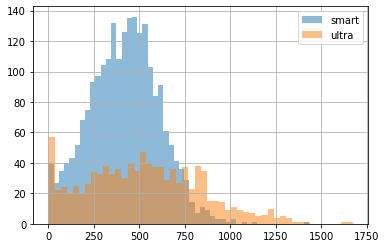

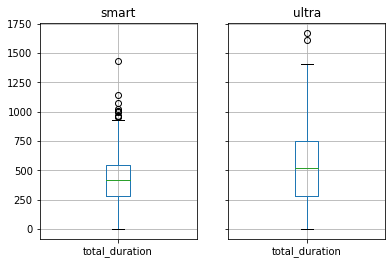

In [40]:
print(users_total.groupby('tariff')['total_duration'].agg(['count', 'mean', 'var', 'std', 'median']))
users_total.groupby('tariff')['total_duration'].hist(bins=50, legend=True, alpha=0.5)

users_total.groupby('tariff').boxplot(column=['total_duration']);

In [41]:
smart_over_tariff = len(users_total.loc[(users_total['tariff'] == 'smart')&(users_total['total_duration'] <=  users_total['minutes_included']), 'total_duration']) / len(users_total.loc[users_total['tariff'] == 'smart', 'total_duration']) * 100
ultra_over_tariff = len(users_total.loc[(users_total['tariff'] == 'ultra')&(users_total['total_duration'] <=  users_total['minutes_included']), 'total_duration']) / len(users_total.loc[users_total['tariff'] == 'ultra', 'total_duration']) * 100
print(f'Доля пользователей-месяцев по тарифу Smart не превысивших объем минут {round(smart_over_tariff,2)}%')
print(f'Доля пользователей-месяцев по тарифу Ultra не превысивших объем минут {round(ultra_over_tariff,2)}%')

Доля пользователей-месяцев по тарифу Smart не превысивших объем минут 66.19%
Доля пользователей-месяцев по тарифу Ultra не превысивших объем минут 100.0%


Распределения по тарифам имеют вид нормального распределение. Единственным отличием от классического нормального распределения является прирост в 0, описывающий пользователей не пользующихся или практически не пользующимися услугами мобильной связи. Об отсутствии скошенности может говорить симетричность 1й и 3й квартилей относительно медиан, а также примерное равенство медиан и средних значений.

Распределение количества минут разговора по тарифу "Smart" имеет вид нормального распределения, с небольшим приростом в районе 0. Среднее значение равно 395 минутам, дисперсия 32393, а стандартное отклонение соотвественно 180 минут. Выборка имеет небольшое количество выбросов - суммарное количество минут в месяц, превышающее 934 минуты (более 15,5 часов в месяц). 33,83% пользователей используют минуты свыше тарифа, оплачиваяя их отдельно.

Распределение количества минут разговора по тарифу "Ultra" имеет вид нормального распределения, с большим приростом в районе 0. Среднее значение равно 497,5 минутам, дисперсия 899957,7, а стандартное отклонение соотвественно 300 минут. Выборка имеет 2 выброса - суммарное количество минут в месяц, превышающее 1400 минут (более 23,3 часов в месяц). В данном тарифе нет пользователей, использующих минуты свер тарифа.

Сравнивая эти распределения между собой, можно отметить следующее:
- Тариф "Smart" используют в 2 раза больше пользователей, чем тариф "Ultra" - 2229 против 985. 
- Среднее значение количества использованных минут тарифа "Ultra" смещено относительно среднего значения по тарифу "Smart" вправо более чем на 100 минут. Из этого следует, что пользователи тарифа "Ultra" в среднем тратят больше времени на разговоры в течение месяца. 
- При этом более высокое значение стандартного отклонения для тарифа "Ultra" говорит о том, что большое количество данных удалено от среднего значения. Многие пользователи тарифа "Ultra" тратят гораздо меньше минут, чем указаное среднее, и также большое количество пользователей тратят намного больше. Об этом же говорит более широкий межквартильный размах для тарифа "Ultra".

        count  mean      var   std  median
tariff                                    
smart    2230 33.37   796.96 28.23   28.00
ultra     986 49.31 2,285.42 47.81   38.00


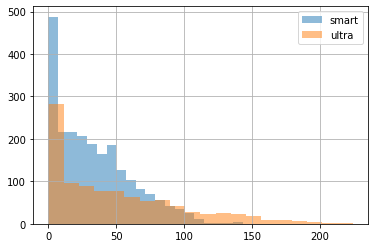

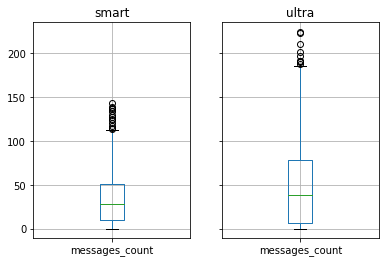

In [42]:
print(users_total.groupby('tariff')['messages_count'].agg(['count', 'mean', 'var', 'std', 'median']))
users_total.groupby('tariff')['messages_count'].hist(bins=20, legend=True, alpha=0.5);
users_total.groupby('tariff').boxplot(column=['messages_count']);

In [43]:
smart_over_tariff = len(users_total.loc[(users_total['tariff'] == 'smart')&(users_total['messages_count'] <=  users_total['messages_included']), 'messages_count']) / len(users_total.loc[users_total['tariff'] == 'smart', 'messages_count']) * 100
ultra_over_tariff = len(users_total.loc[(users_total['tariff'] == 'ultra')&(users_total['messages_count'] <=  users_total['messages_included']), 'messages_count']) / len(users_total.loc[users_total['tariff'] == 'ultra', 'messages_count']) * 100
print(f'Доля пользователей-месяцев по тарифу Smart не превысивших объем сообщений {round(smart_over_tariff,2)}%')
print(f'Доля пользователей-месяцев по тарифу Ultra не превысивших объем сообщений {round(ultra_over_tariff,2)}%')


Доля пользователей-месяцев по тарифу Smart не превысивших объем сообщений 74.71%
Доля пользователей-месяцев по тарифу Ultra не превысивших объем сообщений 100.0%


Распределения по тарифам скошены вправо, при этом для тарифа "Ultra" оно скошено сильнее, об этом говорят как графики функций, так и разница между средними и медианами. Также это хорошо видно на графике boxplot - от 3й квартили до медианы больше, чем расстояние от медианы до 1й квартили.

Распределение количества отправленных сообщений по тарифу "Smart" имеет сильный пик в районе 0. Среднее значение равно 34 сообщения, дисперсия 797, а стандартное отклонение соотвественно 28 сообщений. Выборка имеет значительное количество выбросов - суммарное количество сообщений в месяц, превышающее 118 сообщений. 25.3% пользователей отправляют сообщения свыше тарифа.

Распределение количества отправленных сообщений по тарифу "Ultra" также имеет сильный пик в районе 0. Среднее значение равно 49 сообщений, дисперсия 2285, а стандартное отклонение соотвественно 48 сообщений. Выборка имеет небольшое количество выбросов - значения превышающие 193 сообщения. В данном тарифе нет пользователей, использующих сообщениях свер тарифа.

Сравнивая эти распределения между собой, можно отметить следующее:
- Среднее значение количества использованных минут тарифа "Ultra" смещено относительно среднего значения по тарифу "Smart" вправо. Из этого следует, что пользователи тарифа "Smart" в среднем отправляют больше соощений месяца. 
- При этом более высокое значение стандартного отклонения для тарифа "Ultra" говорит о том, что большое количество данных удалено от среднего значения. Многие пользователи тарифа "Ultra" отправляют гораздо меньше сообщений, чем указаное среднее, и также большое количество пользователей отправлют намного больше. Об этом же говорит более широкий межквартильный размах для тарифа "Ultra", охватывающий почти все значений выборки.
- Высокое значение в районе 0 для обоих тарифов говорит о снижении популярности функции отправки сообщений.

        count  mean   var  std  median
tariff                                
smart    2230 16.32 33.13 5.76   17.00
ultra     986 19.47 97.38 9.87   19.00


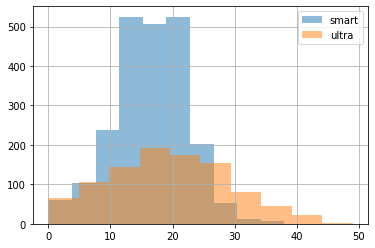

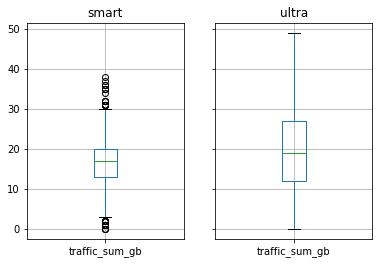

In [44]:
users_total['traffic_sum_gb'] = users_total['traffic_sum_mb']/1024
print(users_total.groupby('tariff')['traffic_sum_gb'].agg(['count', 'mean', 'var', 'std', 'median']))
users_total.groupby('tariff')['traffic_sum_gb'].hist(bins=10, legend=True, alpha=0.5);
users_total.groupby('tariff').boxplot(column=['traffic_sum_gb']);

In [45]:
smart_over_tariff = len(users_total.loc[(users_total['tariff'] == 'smart')&(users_total['traffic_sum_mb'] <=  users_total['mb_per_month_included']), 'traffic_sum_mb']) / len(users_total.loc[users_total['tariff'] == 'smart', 'traffic_sum_mb']) * 100
ultra_over_tariff = len(users_total.loc[(users_total['tariff'] == 'ultra')&(users_total['traffic_sum_mb'] <=  users_total['mb_per_month_included']), 'traffic_sum_mb']) / len(users_total.loc[users_total['tariff'] == 'ultra', 'traffic_sum_mb']) * 100
print(f'Доля пользователей-месяцев по тарифу Smart не превысивших объем траффика {round(smart_over_tariff,2)}%')
print(f'Доля пользователей-месяцев по тарифу Ultra не превысивших объем траффика {round(ultra_over_tariff,2)}%')


Доля пользователей-месяцев по тарифу Smart не превысивших объем траффика 41.52%
Доля пользователей-месяцев по тарифу Ultra не превысивших объем траффика 86.41%


Распределения по тарифам имеют вид нормального распределение. Об отсутствии скошенности может говорить симетричность 1й и 3й квартилей относительно медиан, а также примерное равенство медиан и средних значений.

Распределение объема использованного трафика по тарифу "Smart" имеет вид нормального распределения. Среднее значение равно 16.32 Гб, дисперсия 33.13, а стандартное отклонение соотвественно 5.76 Гб. Выборка имеет значительное количество выбросов - суммарное количество сообщений в месяц, превышающее 33.6 Гб и меньшее 0.4 Гб. При этом, стоит отметить, что среднее значение больше чем объем траффика, входящего в тариф - 15 Гб, что говорит о том, что больше половины половины (58,5%) пользователей тарифа "Smart" вносят плату за интернет сверх абонентской платы.

Распределение объема использованного трафика по тарифу "Ultra" имеет вид нормального распределения. Среднее значение равно 19.47 Гб, дисперсия 97.38, а стандартное отклонение соотвественно 9.87 Гб. Выборка не имеет выбросов. 

Сравнивая эти распределения между собой, можно отметить следующее:
- Среднее значение количества использованных минут тарифа "Ultra" смещено относительно среднего значения по тарифу "Smart" вправо. Из этого следует, что пользователи тарифа "Smart" в среднем отправляют больше соощений месяца. 
- При этом более высокое значение стандартного отклонения для тарифа "Ultra" говорит о том, что большое количество данных удалено от среднего значения. Многие пользователи тарифа "Ultra" отправляют гораздо меньше сообщений, чем указаное среднее, и также большое количество пользователей отправлют намного больше. Об этом же говорит более широкий межквартильный размах для тарифа "Ultra", охватывающий почти все значений выборки.
- Больше половины пользователей тарифа "Smart" используют интернет выше объемов, предусмотренных в тарифе. При этом в случае тарифа "Ultra" наоборот - только меньшая часть клиентов (13,6%) использует дополнительный трафик (свыше 30 Гб).

In [46]:
users_total['not_over_tariff'] = users_total['total_revenue'] <= users_total['rub_monthly_fee']
users_total_tariff = users_total.groupby('tariff')['not_over_tariff'].agg(['count', 'sum'])
users_total_tariff['not_over_tariff_part'] = users_total_tariff['sum'] / users_total_tariff['count']
users_total_tariff

,count,sum,not_over_tariff_part
tariff,,,
smart,2230,568,0.25
ultra,986,852,0.86


        count   mean        var    std  median          sum
tariff                                                     
smart    1662 992.42 647,741.20 804.82  800.00 1,649,401.00
ultra     134 883.21 368,005.41 606.63  750.00   118,350.00


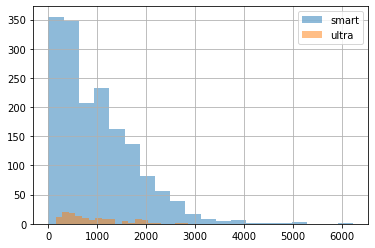

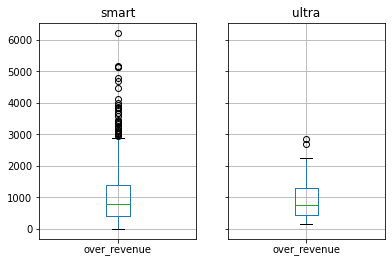

In [47]:
users_total['over_revenue'] = users_total['total_revenue'] - users_total['rub_monthly_fee']
print(users_total[users_total['not_over_tariff'] == False].groupby('tariff')['over_revenue'].agg(['count', 'mean', 'var', 'std', 'median', 'sum']))
users_total[users_total['not_over_tariff'] == False].groupby('tariff')['over_revenue'].hist(bins=20, legend=True, alpha=0.5)
users_total[users_total['not_over_tariff'] == False].groupby('tariff').boxplot(column=['over_revenue']);

На основе проведенного анализа можно сделать следующие выводы о пользователях тарифов "Smart" и "Ultra":
- Большинство пользователей выбирают тариф Smart  - 69,4% пользователей выбирают его. Однако, при этом 74% пользователей-месяцев по тарифу Smart платят за услуги свыше тарифа. При этом большая часть переплат идет за интернет - 56% пользователей доплачивают за дополнительные Мб по тарифу Smart, также 34% пользвателей переплачивают за звонки.
- Переплата в среднем составляет 992.42 руб. При этом разница между тарифами "Smart" и "Ultra" составляет 1500. Здесь можно говорить об ошибке планирования, при которой пользователи тарифа Smart рассчитывают, то смогут уложиться в рамки тарифа, однако как правило не укладываются.
- Тариф "Ultra" выбирают только 30.6% пользователей. Но только 13.6%  пользователей платят за услугу свыше тарифа. Более того, средняя переплата у пользователей тарифа "Ultra" меньше чем у пользователей тарифа "Smart", и станартное отклонение этой переплаты меньше.


Можно сделать вывод:
- Большинству пользователей тарифа "Smart" было бы выгоднее выбирать тариф "Ultra", так как полные расходы с абонентской платой и переплатой едва ли не превосходят абонентскую плату тарифа "Ultra", а объем потребляемых услуг при этом меньше.
- Компании выгоднее рекламировать тариф "Smart", так как с учетом средних объемов потребления услуг, то переплаты для тарифа "Smart" выгоднее чем абонентская плата от тарифа "Ultra".

## Проверка гипотез

In [48]:
alpha = .05

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;


<b>H0</b>: в качестве нулевой гипотезы возьмем утверждение, что средняя выручка пользователей тарифов "Ultra" и "Smart" не разичаются. 
    
<b>H1</b>: тогда в качестве альтернативной гипотезой можно взять утверждение, что тарифы «Ultra» и «Smart» различаются.

Прежде всего сравним распределение средней выручки пользователей тарфов.

Результаты по тарифу "Ultra" имеют меньший разброс, несмотря на то, что средняя выручка для них выше.

        count     mean        var    std
tariff                                  
smart    2230 1,289.64 669,730.76 818.37
ultra     986 2,070.03 141,387.71 376.02


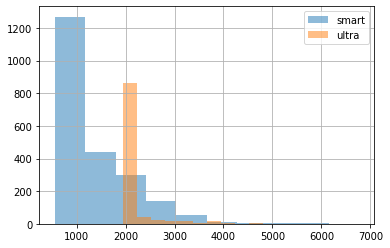

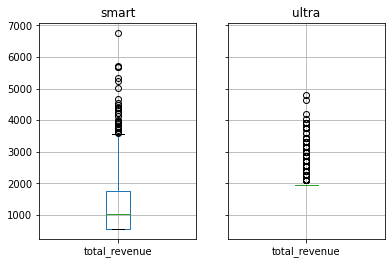

In [49]:
print(users_total.groupby('tariff')['total_revenue'].agg(['count', 'mean', 'var', 'std']))
users_total.groupby('tariff')['total_revenue'].hist(bins=10, legend=True, alpha=0.5);
users_total.groupby('tariff').boxplot(column=['total_revenue']);

Для того, чтобы сравнить выборки - они должны быть одного размера. Для этого используем метод sample() и возьмем из обеих таблиц количество данных равное минимальному из двух объемов таблиц. В качестве критерия проверки используем t-тест. При, учитывая разницу дисперсий, укажем equal_var = False.

In [50]:
sample_len = min(len(users_total[users_total['tariff'] == 'smart']), len(users_total[users_total['tariff'] == 'ultra']))
users_smart_sample = users_total[users_total['tariff'] == 'smart']['total_revenue'].sample(sample_len)
users_ultra_sample = users_total[users_total['tariff'] == 'ultra']['total_revenue'].sample(sample_len)

In [51]:
results = st.ttest_ind(users_smart_sample, users_ultra_sample, equal_var = False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отбрасываем нулевую гипотезу")
else:
    print("Отбрасываем альтернативную гипотезу")

p-значение:  1.849272306651272e-129
Отбрасываем нулевую гипотезу


Согласно проведенному иследованию, нулевую гипотезу можно отбросить - средние выручки тарифов Ultra и Smart отличаются друг от друга.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

<b>H0</b>: в качестве нулевой гипотезы возьмем утверждение, что средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов не разичаются. 
    
<b>H1</b>: тогда в качестве альтернативной гипотезой можно взять утверждение, что средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов разичаются.

Прежде всего сравним распределение средней выручки пользователей по городам.

Результаты по пользователям из разных городов очень похожи, учитывая значения средних и стандартных отклонений. 

               count     mean        var    std
city_moscow                                    
Москва           611 1,546.71 565,636.47 752.09
Прочие города   2605 1,524.73 654,069.57 808.75


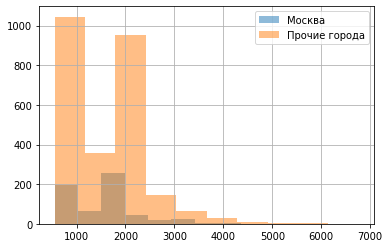

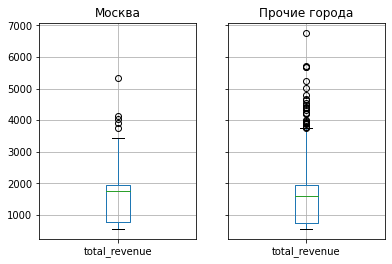

In [52]:
users_total['city_moscow'] = 'Прочие города'
users_total.loc[users_total['city'] == 'Москва', 'city_moscow'] = 'Москва'

print(users_total.groupby('city_moscow')['total_revenue'].agg(['count', 'mean', 'var', 'std']))
users_total.groupby('city_moscow')['total_revenue'].hist(bins=10, legend=True, alpha=0.5);
users_total.groupby('city_moscow').boxplot(column=['total_revenue']);

Для того, чтобы сравнить выборки - они должны быть одного размера. Для этого используем метод sample() и возьмем из обеих таблиц количество данных равное минимальному из двух объемов таблиц. В качестве критерия проверки используем t-тест. При, учитывая близость дисперсий, не будем указывать параметр equal_var.

In [53]:
sample_len = min(len(users_total[users_total['city_moscow'] == 'Москва']), len(users_total[users_total['city_moscow'] == 'Прочие города']))
users_moscow_sample = users_total[users_total['city_moscow'] == 'Москва']['total_revenue'].sample(sample_len)
users_other_sample = users_total[users_total['city_moscow'] == 'Прочие города']['total_revenue'].sample(sample_len)

results = st.ttest_ind(users_moscow_sample, users_other_sample)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отбрасываем нулевую гипотезу")
else:
    print("Отбрасываем альтернативную гипотезу")

p-значение:  0.7015234024331114
Отбрасываем альтернативную гипотезу


Согласно проведенному иследованию, альтернативную  гипотезу можно отбросить - средние выручки тарифов Москвы  и других регионов не отличаются друг от друга.

Проинтерпретируем полученные результаты с точки зрения статистики.
<b>p-value</b> - в данном случае, это вероятность того, что при истинности нулевой гипотезы, сравниваемые выборки были взяты из совокупностей с одинаковыми метрками. Если <b>p-value</b> меньше некоторго уровня значимости (<i>alpha</i> = 5%), то скорее всего данные выборки были взяты из совокупностей с разными метриками и тогд нулевую гипотезу можно отбросить.

1. Сравнение средней выручки пользователей тарифов «Ультра» и «Смарт» - p-значение:  3.897703930649487e-134. Это означает, что вероятность, что выборки для тарифа "Smart" и тарифа "Ultra" взяты из совокупностей с одинаковыми метриами, равна 4 * 10^-32 %, что гораздо меньше определенного нами уровня значимости 5%. Из этого следует, чо мы можем отбросить нулевую гипотезу о равенстве средних выручек.

2. Сравнение средних выручек пользователей из Москвы и из других регионов - p-значение:  0.5256659369687924. Это означает, что вероятность, что выборки для пользователей из Москвы и пользователей из других регионов взяты из совокупностей с одинаковыми метриами, равна 52%, что гораздо больше определенного нами уровня значимости 5%. Из этого следует, чо мы не можем отбросить нулевую гипотезу о равенстве средних выручек и должны отбросить альтернативную - ою их различии.

In [54]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:

    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.19124505225722097
Не получилось отвергнуть нулевую гипотезу


## Общие выводы

На основе проведенного анализа можно сделать следующие выводы о пользователях тарифов "Smart" и "Ultra":

- Большинство пользователей выбирают тариф Smart - 69,4% пользователей выбирают его. Однако, при этом 74% пользователей-месяцев по тарифу Smart платят за услуги свыше тарифа. При этом большая часть переплат идет за интернет - 56% пользователей доплачивают за дополнительные Мб по тарифу Smart, также 34% пользвателей переплачивают за звонки.
- Переплата в среднем составляет 992.42 руб. При этом разница между тарифами "Smart" и "Ultra" составляет 1500. Здесь можно говорить об ошибке планирования, при которой пользователи тарифа Smart рассчитывают, то смогут уложиться в рамки тарифа, однако как правило не укладываются.
- Тариф "Ultra" выбирают только 30.6% пользователей. Но только 13.6% пользователей платят за услугу свыше тарифа. Более того, средняя переплата у пользователей тарифа "Ultra" меньше чем у пользователей тарифа "Smart", и станартное отклонение этой переплаты меньше.
- Большинству пользователей тарифа "Smart" было бы выгоднее выбирать тариф "Ultra", так как полные расходы с абонентской платой и переплатой едва ли не превосходят абонентскую плату тарифа "Ultra", а объем потребляемых услуг при этом меньше.
- Компании выгоднее рекламировать тариф "Smart", так как с учетом средних объемов потребления услуг, то переплаты для тарифа "Smart" выгоднее чем абонентская плата от тарифа "Ultra".
- Разница между средней выручкой тарифа "Smart" отличается от средней выручки тарифа "Ultra".
- Однако, нет разницы между средней выручкой между Москвой и другими регионами.